In [7]:
import cv2 
from matplotlib import pyplot as plt

In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random
import os
import csv
import cv2
from frame import FLCDataset, visualize_transformed_image


In [35]:
train_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_train.csv", r"C:\Users\lucyc\Desktop\face_loc")
val_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_val.csv", r"C:\Users\lucyc\Desktop\face_loc")
test_dataset = FLCDataset(r"C:\Users\lucyc\Desktop\face_loc_test.csv", r"C:\Users\lucyc\Desktop\face_loc")

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=4)

In [36]:
a, b, c = next(iter(val_loader))

In [37]:
a.shape

torch.Size([128, 3, 12, 12])

In [38]:
def get_args(b):
    return [int(float(x)//1) for x in b.split()]

In [39]:
#visualize_transformed_image(a[6],get_args(b[6]),get_args(b[6]))

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)
torch.cuda.empty_cache()

cuda:0


In [41]:
class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        # 定义网络层
        self.conv1 = nn.Conv2d(3, 10, 3)  #12 -> 10 -> maxp -> 5
        self.conv2 = nn.Conv2d(10, 16, 3) #5 -> 3
        self.conv3 = nn.Conv2d(16, 32, 3) #3 -> 1

        self.face_det = nn.Conv2d(32, 2, 1) #1 -> 1
        self.bbox = nn.Conv2d(32, 4, 1) #1 -> 1
        self.landmark = nn.Conv2d(32, 10, 1) #1 -> 1

    def forward(self, x):
        # 定义前向传播
        x = F.relu(self.conv1(x)) #10
        x = F.max_pool2d(x, 2) #5
        x = F.relu(self.conv2(x)) #3
        x = F.relu(self.conv3(x)) #1

        facedet = self.face_det(x)
        bbox = self.bbox(x)
        landmark = self.landmark(x)

        facedet = torch.flatten(facedet, 1)
        bbox = torch.flatten(bbox, 1)
        landmark = torch.flatten(landmark, 1)

        return facedet, bbox, landmark


In [42]:
class PNetLoss(nn.Module):
    def __init__(self):
        super(PNetLoss, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype in ["2", "3", "4"]:
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0.5 * bbox_loss + facedet_loss)

            elif ltype == "5":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0.5 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        return loss_total

In [43]:
class PNetLossFace(nn.Module):
    def __init__(self):
        super(PNetLossFace, self).__init__()
        # 初始化可以在这里完成，如果有必要的话

    def forward(self, facedet, bbox, landmark, label, ltypes):
        # 假设 'device' 是一个全局变量或已经事先定义好的
        loss_total = torch.tensor(0.0, device=device, requires_grad=True)

        face = torch.tensor([1.0, 0.0], device=device)
        not_face = torch.tensor([0.0, 1.0], device=device)
        
        for i, ltype in enumerate(ltypes):
            
            if ltype == "2":
                # 对于类型2，只需要面部检测损失
                # 一个两个元素的tensor
                facedet_loss = F.cross_entropy(facedet[i], not_face)

                loss_total = loss_total + facedet_loss

            elif ltype in ["1", "0"]:
                # 对于类型1和0，计算边界框损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                bbox_loss = F.mse_loss(bbox[i], label[i][:4])

                loss_total = loss_total + (0 * bbox_loss + facedet_loss)

            elif ltype == "3":
                # 对于类型3，计算关键点损失
                facedet_loss = F.cross_entropy(facedet[i], face)

                landmark_loss =F.mse_loss(landmark[i], label[i])
                
                loss_total = loss_total + (0 * landmark_loss + facedet_loss)

        loss_total = loss_total / len(ltypes)
        #loss_total = loss_total
        
        return loss_total

In [44]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)


In [45]:
model.train()  # 设置模型为训练模式

train_x = []
train_loss_y = []

train_loss_acc = 0.
train_num = 0

for inputs in train_loader:
    
    img_tensor = inputs[0].to(device)
    label = inputs[1].to(device)
    ltypes = inputs[2]

    facedet, bbox, landmark = model(img_tensor)
    optimizer.zero_grad()  # 清除之前的梯度
    loss = criterion(facedet, bbox, landmark, label, ltypes)
    # 反向传播和优化
    loss.backward()  # 反向传播计算当前的梯度
    optimizer.step()  # 更新参数

    train_loss_acc += loss.item()
    train_num += 1

    train_x.append(train_num)
    train_loss_y.append(loss.item())
    
    print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*128, len(train_dataset))
    

1 13.657028198242188 0.06828514099121094 128 178758
2 14.309858322143555 0.1398344326019287 256 178758
3 14.30003547668457 0.21133460998535156 384 178758
4 14.978670120239258 0.28622796058654787 512 178758
5 12.92046070098877 0.3508302640914917 640 178758
6 14.961057662963867 0.425635552406311 768 178758
7 15.261960983276367 0.5019453573226929 896 178758
8 11.950431823730469 0.5616975164413452 1024 178758
9 14.590614318847656 0.6346505880355835 1152 178758
10 15.919295310974121 0.7142470645904541 1280 178758
11 11.786123275756836 0.7731776809692383 1408 178758
12 16.324417114257812 0.8547997665405274 1536 178758
13 14.810253143310547 0.9288510322570801 1664 178758
14 14.5360746383667 1.0015314054489135 1792 178758
15 15.972712516784668 1.081394968032837 1920 178758
16 14.602092742919922 1.1544054317474366 2048 178758
17 15.546650886535645 1.2321386861801147 2176 178758
18 13.918160438537598 1.3017294883728028 2304 178758
19 14.303766250610352 1.3732483196258545 2432 178758
20 12.928866

In [ ]:
# 验证多任务训练在 单一任务上的表现 是否有提升
# 人脸平均绝对值误差 单任务        全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.135152058410645
# 人脸平均绝对值误差 均方差 多任务 全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 8.84007318687439
# 人脸交叉熵损失  单任务          全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 11.208772300338746
# 人脸交叉熵损失 均方差  多任务   全训练样本 一批次 Adam lr=0.0001 face_val_loss_avg: 13.04701942062378

In [48]:

criterion = PNetLossFace()

model.eval() 
val_loss_acc = 0
val_num = 0
with torch.no_grad():
    for inputs in val_loader:
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        loss = criterion(facedet, bbox, landmark, label, ltypes)

        val_loss_acc += loss.item()
        val_num += 1

        print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(val_dataset))

print("val loss avg:", val_loss_acc/val_num)


1 0.5385095477104187 0.5385095477104187 32 14896
2 0.5627516508102417 0.5506305992603302 64 14896
3 0.46651849150657654 0.522593230009079 96 14896
4 0.5935531258583069 0.540333203971386 128 14896
5 0.4952317476272583 0.5313129127025604 160 14896
6 0.3902851641178131 0.5078082879384359 192 14896
7 0.5196511745452881 0.5095001288822719 224 14896
8 0.48110488057136536 0.5059507228434086 256 14896
9 0.5453327298164368 0.5103265013959672 288 14896
10 0.46650391817092896 0.5059442430734634 320 14896
11 0.5375657677650452 0.5088189271363345 352 14896
12 0.39507758617401123 0.4993404820561409 384 14896
13 0.42803797125816345 0.4938556735332196 416 14896
14 0.5406860113143921 0.49720069766044617 448 14896
15 0.5445060133934021 0.5003543853759765 480 14896
16 0.5048081278800964 0.500632744282484 512 14896
17 0.47216346859931946 0.4989580810070038 544 14896
18 0.5027087330818176 0.49916645056671566 576 14896
19 0.5141762495040894 0.4999564399844722 608 14896
20 0.47783657908439636 0.4988504469394

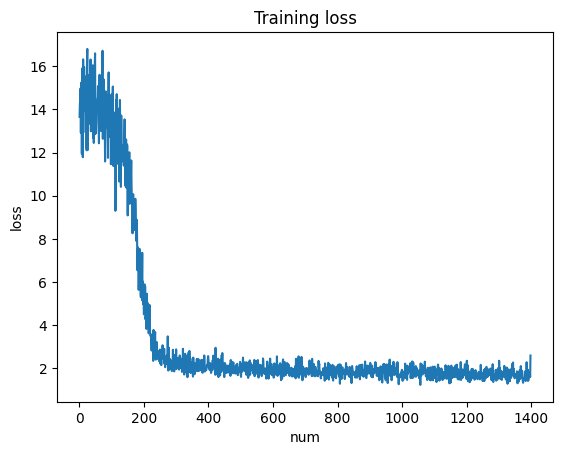

In [49]:
# draw loss curve
plt.plot(train_x, train_loss_y, label='train')
plt.xlabel('num')
plt.ylabel('loss')
plt.title('Training loss')
plt.show()



In [50]:
# 保存模型
torch.save(model, 'face_loc_p_NN.pth')

In [51]:
# load model
model_trained = torch.load('face_loc_p_2.pth')
model_trained.eval()  # 设置模型为评估/测试模式


PNet(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (face_det): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (bbox): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (landmark): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [52]:
aa = iter(test_loader)

In [56]:

a, b, c = next(aa)

In [63]:
def get_argsn(b):
    return [int(float(x)//1) for x in b]

def is_face(i):
    if i == "0":
        return "face"
    if i == "1":
        return "face"
    if i == "2":
        return "not face"
    if i == "3":
        return "not face"
    if i == "4":
        return "not face"
    if i == "5":
        return "face"

In [73]:
right = 0
total = 0
for i in range(128):
    # visualize_transformed_image(a[i],get_argsn(b[i]),get_argsn(b[i]))
    # print(is_face(c[i]))

    face_det, bbox, landmark = model_trained(a[i].to(device))
    # if face_det[0] - face_det[1] > 1.5:
    #     print("face")
    #     visualize_transformed_image(a[i],get_argsn(bbox),get_argsn(landmark))   
    # else:
    #     print("not face")
    #     visualize_transformed_image(a[i],[0,0,0,0],None)
    
    if face_det[0] > face_det[1] and is_face(c[i]) == "face":
        right += 1
    if face_det[0] < face_det[1] and is_face(c[i]) == "not face":
        right += 1

    total += 1

print("total: {}".format(total))
print("right: {}".format(right))
print("accuracy: {}".format(right/128))

total: 128
right: 97
accuracy: 0.7578125


In [ ]:
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)

model = PNet()
print(model)

model.to(device)  # 将模型发送到GPU，如果有的话

# 定义损失函数和优化器
criterion = PNetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 训练模型
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式

    train_x = []
    train_loss_y = []

    train_loss_acc = 0.
    train_num = 0

    for inputs in train_loader:
        
        img_tensor = inputs[0].to(device)
        label = inputs[1].to(device)
        ltypes = inputs[2]

        facedet, bbox, landmark = model(img_tensor)
        optimizer.zero_grad()  # 清除之前的梯度
        loss = criterion(facedet, bbox, landmark, label, ltypes)
        # 反向传播和优化
        loss.backward()  # 反向传播计算当前的梯度
        optimizer.step()  # 更新参数

        train_loss_acc += loss.item()
        train_num += 1

        train_x.append(train_num)
        train_loss_y.append(loss.item())
        print(train_num,loss.item(),sum(train_loss_y[-200:])/200, train_num*32, len(train_dataset))

    model.eval() 
    val_loss_acc = 0
    val_num = 0
    with torch.no_grad():
        for inputs in val_loader:
            img_tensor = inputs[0].to(device)
            label = inputs[1].to(device)
            ltypes = inputs[2]

            facedet, bbox, landmark = model(img_tensor)
            loss = criterion(facedet, bbox, landmark, label, ltypes)

            val_loss_acc += loss.item()
            val_num += 1

            print(val_num,loss.item(),val_loss_acc/val_num, val_num*32, len(train_dataset))

    print("Epoch [{}/{}], Loss: {:.2f}, Val_loss: {:.2f}".format(epoch+1, num_epochs, val_loss_acc/val_num, val_loss_acc/val_num))

    # draw loss curve
    plt.plot(train_x, train_loss_y, label='train')
    plt.xlabel('num')
    plt.ylabel('loss')
    plt.title('Training loss')
    plt.show()
    
    input("Press Enter to continue...")
